In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
# 得到的结果poly_features是一个200x20的矩阵（对于200x1的矩阵和1x20的矩阵，np.power()函数利用了python当中的广播机制）
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# 对poly_features的每一列进行操作
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的shape：(n_train + n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [26]:
# 将numpy.ndarray转化为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]
true_w[:2], features[:2], poly_features[:2, :], labels[:2]

D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(tensor([5.0000, 1.2000]),
 tensor([[-1.5598],
         [ 0.9721]]),
 tensor([[ 1.0000e+00, -1.5598e+00,  1.2164e+00, -6.3245e-01,  2.4662e-01,
          -7.6934e-02,  2.0000e-02, -4.4565e-03,  8.6888e-04, -1.5058e-04,
           2.3488e-05, -3.3305e-06,  4.3290e-07, -5.1940e-08,  5.7868e-09,
          -6.0173e-10,  5.8660e-11, -5.3821e-12,  4.6638e-13, -3.8287e-14],
         [ 1.0000e+00,  9.7210e-01,  4.7249e-01,  1.5310e-01,  3.7207e-02,
           7.2338e-03,  1.1720e-03,  1.6276e-04,  1.9777e-05,  2.1361e-06,
           2.0765e-07,  1.8351e-08,  1.4865e-09,  1.1116e-10,  7.7184e-12,
           5.0020e-13,  3.0390e-14,  1.7378e-15,  9.3849e-17,  4.8016e-18]]),
 tensor([-4.5590,  5.3218]))

In [27]:
# 评估给定数据集上的模型损失
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [37]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='mean')
    input_shape = train_features.shape[1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9889903  1.2339921 -3.3663614  5.541672 ]]


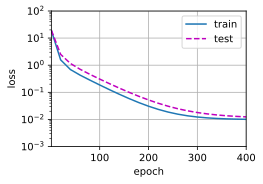

In [38]:
# 我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。 结果表明，该模型能有效降低训练损失和测试损失。
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.2775934 3.3500686]]


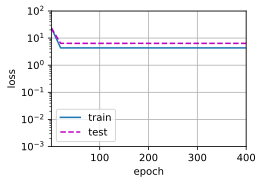

In [39]:
# 线性函数拟合(欠拟合)
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9959254   1.2582105  -3.3769915   5.290475   -0.06923129  1.0941318
   0.1195785  -0.01997027  0.05891128 -0.08840063  0.2043304  -0.1443696
  -0.20263988 -0.1142652  -0.09298803 -0.08978979  0.09821254  0.21365893
  -0.08026795  0.20850629]]


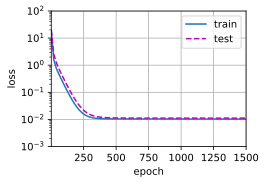

In [40]:
# 从多项式特征中选取所有维度
# 现在，让我们尝试使用一个阶数过高的多项式来训练模型。 在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。 因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。 虽然训练损失可以有效地降低，但测试损失仍然很高。 结果表明，复杂模型对数据造成了过拟合。
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)